### Set up(Run when restart)

In [ ]:

import pandas as pd
import zipfile
import os
from tqdm import tqdm
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Key word Filter and Classification for AI-related article

#### Keyword filter: break down the df into chunks

In [ ]:


# # Define source zip file path (adjust name if needed!)
# zip_path = '/content/drive/MyDrive/thesis/data/nyt_articles_30yrs.csv.zip'

# # Define destination folder
# dest_folder = '/content/drive/MyDrive/thesis/data/'

# # Make sure the folder exists (just in case)
# os.makedirs(dest_folder, exist_ok=True)

# # Unzip
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(dest_folder)

# print("✅ Unzipped successfully!")


KeyboardInterrupt: 

In [ ]:
data_path = '/content/drive/MyDrive/thesis/data/nyt_articles_30yrs.csv'
df = pd.read_csv(data_path)
#df.head()

In [ ]:
df['text'] = (df['headline'].fillna('') + ' ' + df['abstract'].fillna('') + ' ' + df['lead_paragraph'].fillna('')).str.lower()
df.head()

,headline,abstract,lead_paragraph,pub_date,section_name,type_of_material,web_url,keywords,year,month,text
0,Corrections,Correction of Dec 30 caption with article abou...,A picture in some copies on Thursday with the ...,2005-01-01 05:00:00+00:00,New York,Correction,https://www.nytimes.com/2005/01/01/nyregion/pa...,"Accidents and Safety, Railroads, Correction St...",2005.0,1.0,corrections correction of dec 30 caption with ...
1,Disaster Relief: Is America Doing Enough?,Ewart Stuger letter says type of Marshall Plan...,To the Editor:,2005-01-01 05:00:00+00:00,Opinion,Letter,https://www.nytimes.com/2005/01/01/opinion/dis...,"Far East, South and Southeast Asia and Pacific...",2005.0,1.0,disaster relief: is america doing enough? ewar...
2,Disaster Relief: Is America Doing Enough?,C Flesch letter holds that tsunami warning sys...,To the Editor:,2005-01-01 05:00:00+00:00,Opinion,Letter,https://www.nytimes.com/2005/01/01/opinion/dis...,"Far East, South and Southeast Asia and Pacific...",2005.0,1.0,disaster relief: is america doing enough? c fl...
3,Editors' Note,New York Times is making change to listing of ...,"Starting in the new year, The Times is making ...",2005-01-01 05:00:00+00:00,New York,Editors' Note,https://www.nytimes.com/2005/01/01/nyregion/ed...,New York Times,2005.0,1.0,editors' note new york times is making change ...
4,Techniques That Might Smile Upon Mona Lisa,Article on research conducted by Smithsonian I...,"WASHINGTON, Dec. 31 - Art and science don't of...",2005-01-01 05:00:00+00:00,Arts,News,https://www.nytimes.com/2005/01/01/arts/design...,"Smithsonian Institution, MECKLENBURG, MARION, ...",2005.0,1.0,techniques that might smile upon mona lisa art...


In [ ]:

# Split a DataFrame into small batches

def split_dataframe(df, chunk_size=1000):
    for idx, start in enumerate(range(0, df.shape[0], chunk_size)):
        yield df.iloc[start:start + chunk_size], idx


# Filter for Keywords function
def filter_ai_keywords(df, text_col):
  import re

  def load_ai_pattern(keyword_path='/content/drive/MyDrive/thesis/data/ai_keywords.txt'):
      with open(keyword_path) as f:
          ai_keywords = [line.strip().lower() for line in f if line.strip()]
      escaped_keywords = [
          re.escape(kw) if '.' in kw else r'\b' + re.escape(kw) + r'\b'
          for kw in ai_keywords
      ]
      pattern = re.compile(r'(?:' + '|'.join(escaped_keywords) + ')', flags=re.IGNORECASE)
      return pattern

  pattern = load_ai_pattern()

  df_keywords_filtered = df[df[text_col].str.contains(pattern, regex=True, na=False)].copy()

  return df_keywords_filtered


In [ ]:
# Assuming your full dataframe is loaded as df
# Example: df = pd.read_csv('/content/nyt_full_data.csv')

# Set up saving folder
os.makedirs('/content/drive/MyDrive/thesis/data/filtered_chunks', exist_ok=True)

# Set your batch size
chunk_size = 1000

# Initialize
chunk_counter = 0

# Process
for chunk, chunk_counter in tqdm(split_dataframe(df, chunk_size=chunk_size), desc="Filtering Chunks"):
    chunk_filename = f'/content/drive/MyDrive/thesis/data/filtered_chunks_{chunk_counter}.csv'

    # Check if already processed
    if os.path.exists(chunk_filename):
        continue  # Skip this chunk, already done

    # Filter and save
    filtered_chunk = filter_ai_keywords(chunk, text_col='text')
    filtered_chunk.to_csv(chunk_filename, index=False)


Filtering Chunks: 2737it [1:21:46,  1.79s/it]


In [ ]:
#combining chunks into one df

import pandas as pd
import glob


chunks_folder = '/content/drive/MyDrive/thesis/data/'

# Use glob to find all filtered chunk files
all_chunk_files = sorted(glob.glob(chunks_folder + 'filtered_chunks_*.csv'))

print(f"Found {len(all_chunk_files)} chunk files.")

# Merge all chunks
merged_chunks = []
for file in all_chunk_files:
    chunk = pd.read_csv(file)
    merged_chunks.append(chunk)

# Concatenate into one big dataframe
df_keywords_filtered = pd.concat(merged_chunks, ignore_index=True)

print(f"Total articles after merging: {len(df_keywords_filtered)}")


Found 2737 chunk files.
Total articles after merging: 52497


<ipython-input-11-517911448dc0>:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_keywords_filtered = pd.concat(merged_chunks, ignore_index=True)


In [ ]:
print(f"Number of AI-related articles found(keyword filter): {len(df_keywords_filtered)}")

df_keywords_filtered.to_csv('/content/drive/MyDrive/thesis/data/df_keywords_filtered.csv', index=False)

Number of AI-related articles found(keyword filter): 52497


#### Transformer model for classification

In [ ]:
df_keywords_filtered = pd.read_csv('/content/drive/MyDrive/thesis/data/df_keywords_filtered.csv')

In [ ]:
from transformers import pipeline

def classify_ai(df, text_col="headline", threshold=0.85):
    """
    Return a df containing only the rows that contain AI-related keywords
    and the row classified as ai related.
    """

    classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")
    labels = ["AI-related", "Not AI-related"]

    # Transformer zero-shot classification
    def classify_text(text):
        result = classifier(text, candidate_labels=labels)
        return result['labels'][0] == "AI-related" and result['scores'][0] >= threshold

    df["ai_classified"] = df[text_col].apply(classify_text)

    return df[df["ai_classified"]]


In [ ]:
# Drop rows where 'headline' is missing or not a string
df_keywords_filtered = df_keywords_filtered[df_keywords_filtered['headline'].apply(lambda x: isinstance(x, str) and len(x.strip()) > 0)]

df_keywords_filtered_classified = classify_ai(df_keywords_filtered, text_col="headline", threshold=0.8)

print(df_keywords_filtered_classified.head())
print(f"Number of AI-related articles found(both filter and classified): {len(df_keywords_filtered_classified)}")

NameError: name 'df_keywords_filtered' is not defined

In [ ]:
df_keywords_filtered_classified.to_csv('/content/drive/MyDrive/thesis/data/df_keywords_filtered_classified.csv', index=False)

#### Visualize

In [ ]:
df_raw = pd.read_csv('/content/drive/MyDrive/thesis/data/nyt_articles_30yrs.csv')
df_key = pd.read_csv('/content/drive/MyDrive/thesis/data/df_keywords_filtered.csv')
df_class = pd.read_csv('/content/drive/MyDrive/thesis/data/df_keywords_filtered_classified.csv')

In [ ]:
sizes = [len(df_raw), len(df_key), len(df_class)]
labels = ['Raw Data', 'After Keyword Filter', 'After Classification']

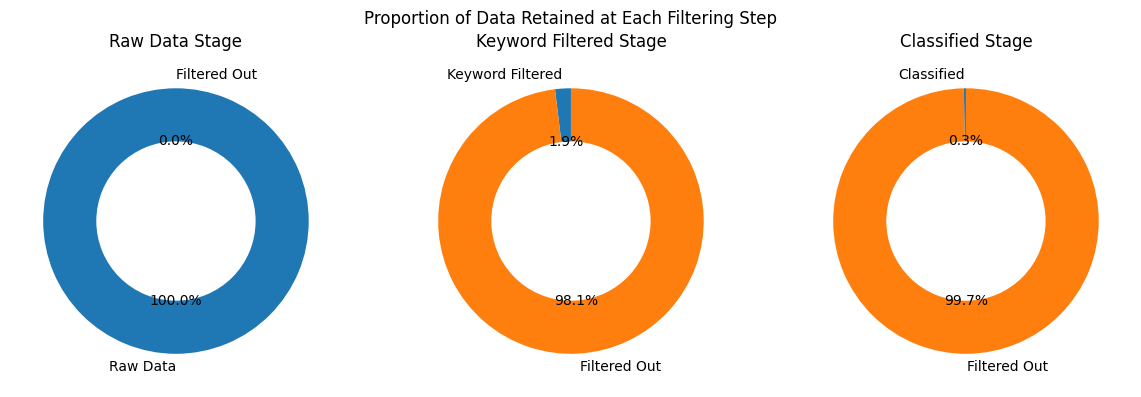

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

for i, size in enumerate(sizes):
    axs[i].pie([size, sizes[0] - size], labels=[labels[i], 'Filtered Out'],
               autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.4))
    axs[i].set_title(f"{labels[i]} Stage")

plt.suptitle('Proportion of Data Retained at Each Filtering Step')
plt.tight_layout()
plt.show()

In [ ]:
import plotly.express as px

data = dict(
    stage=["Raw Data", "Keyword Filtered", "Classified"],
    count=[len(df_raw), len(df_key), len(df_class)]
)

fig = px.funnel(data, x="count", y="stage", title="Filtering Funnel")
fig.show()


### Sentiment Index

In [ ]:

from textblob import TextBlob

In [ ]:
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

# Apply to your text
df_keywords_filtered_classified = pd.read_csv('/content/drive/MyDrive/thesis/data/df_keywords_filtered_classified.csv')
df_keywords_filtered_classified["sentiment"] = df_keywords_filtered_classified["text"].apply(get_sentiment)


In [ ]:
df_keywords_filtered_classified["sentiment"] = df_keywords_filtered_classified["sentiment"].round(3)
df_keywords_filtered_classified.head()

,headline,abstract,lead_paragraph,pub_date,section_name,type_of_material,web_url,keywords,year,month,text,ai_classified,sentiment
0,How Q Found Her Groove,Majority of Japanese immigrants in New York Ci...,"HER arm locks like a robot's, then pops from t...",2005-01-30 05:00:00+00:00,New York,News,https://www.nytimes.com/2005/01/30/nyregion/th...,"Japan, East Village (NYC), New York City, Soci...",2005.0,1.0,how q found her groove majority of japanese im...,True,0.063
1,Is I.B.M.'s Lenovo Proposal a Threat to Nation...,Committee on Foreign Investment in US is expec...,"On its face, I.B.M.'s planned sale of its pers...",2005-01-31 05:00:00+00:00,Business Day,News,https://www.nytimes.com/2005/01/31/technology/...,"China, International Business Machines Corpora...",2005.0,1.0,is i.b.m.'s lenovo proposal a threat to nation...,True,-0.040
2,Microsoft Introduces Its Own Search Service,Microsoft is introducing its homegrown search ...,Two years after saying it planned to enter the...,2005-02-01 05:00:00+00:00,Business Day,News,https://www.nytimes.com/2005/02/01/technology/...,"MSN, Microsoft Corp, Yahoo Inc, Microsoft Corp...",2005.0,2.0,microsoft introduces its own search service mi...,True,0.600
3,"Google Defies Its Warning, Growing Briskly",Google says its sales and profit margins grew ...,Correction Appended,2005-02-02 05:00:00+00:00,Business Day,News,https://www.nytimes.com/2005/02/02/technology/...,"Google Inc, Sales, ADVERTISING AND MARKETING, ...",2005.0,2.0,"google defies its warning, growing briskly goo...",True,-0.058
4,"Google Wants to Dominate Madison Avenue, Too","IN many ways, Larry Page and Sergey Brin seem ...","Mountain View, Calif. - IN many ways, Larry Pa...",2005-10-30 05:00:00+00:00,Business Day,News,https://www.nytimes.com/2005/10/30/business/yo...,"Google Inc, ADVERTISING, Computers and the Int...",2005.0,10.0,"google wants to dominate madison avenue, too i...",True,0.001


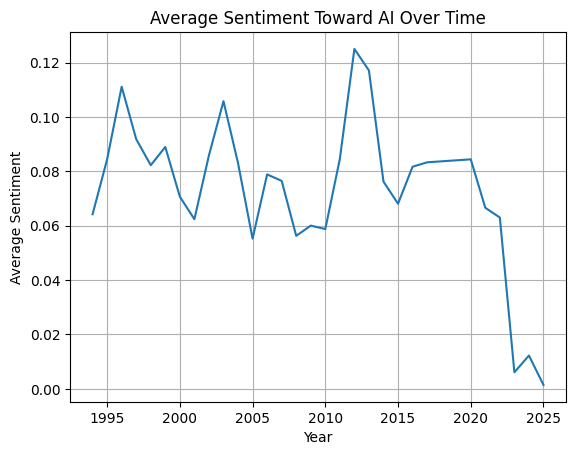

In [ ]:
# Assume you have a 'pub_date' column, if not, skip this step
df_keywords_filtered_classified['year'] = pd.to_datetime(df_keywords_filtered_classified['pub_date']).dt.year

# Average sentiment per year
sentiment_by_year = df_keywords_filtered_classified.groupby('year')['sentiment'].mean().reset_index()

# Plot
import matplotlib.pyplot as plt

plt.plot(sentiment_by_year['year'], sentiment_by_year['sentiment'])
plt.title('Average Sentiment Toward AI Over Time')
plt.xlabel('Year')
plt.ylabel('Average Sentiment')
plt.grid(True)
plt.show()


In [ ]:
def categorize_sentiment(score):
    if score > 0.05:
        return "Positive"
    elif score < -0.05:
        return "Negative"
    else:
        return "Neutral"

In [ ]:
# Create a new 'sentiment_label' column
df_keywords_filtered_classified["sentiment_label"] = df_keywords_filtered_classified["sentiment"].apply(categorize_sentiment)


In [ ]:
df_keywords_filtered_classified["sentiment_label"].value_counts()

,count
sentiment_label,
Positive,3502
Neutral,2193
Negative,1189


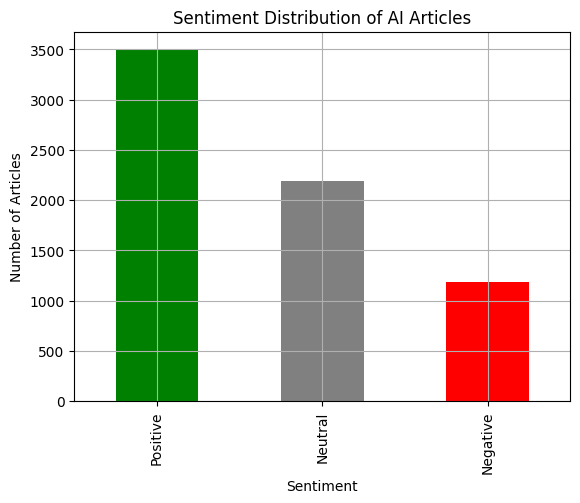

In [ ]:
import matplotlib.pyplot as plt

df_keywords_filtered_classified["sentiment_label"].value_counts().plot(kind='bar', color=['green', 'grey', 'red'])
plt.title('Sentiment Distribution of AI Articles')
plt.xlabel('Sentiment')
plt.ylabel('Number of Articles')
plt.grid(True)
plt.show()


In [ ]:
# Parse pub_date
data_path = '/content/drive/MyDrive/thesis/data/nyt_articles_30yrs.csv'
df = pd.read_csv(data_path)
df['pub_date'] = pd.to_datetime(df['pub_date'])
df['year'] = df['pub_date'].dt.year
df_keywords_filtered_classified['year'] = pd.to_datetime(df_keywords_filtered_classified['pub_date']).dt.year


In [ ]:
# Group classified AI articles by year and sentiment
sentiment_counts = df_keywords_filtered_classified.groupby(['year', 'sentiment_label']).size().unstack(fill_value=0)

# Group total articles by year
total_articles_per_year = df['year'].value_counts().sort_index()


In [ ]:
# Align indices properly
sentiment_counts = sentiment_counts.reindex(total_articles_per_year.index).fillna(0)

# Calculate percentage for each sentiment
sentiment_percentages = sentiment_counts.div(total_articles_per_year, axis=0) * 100


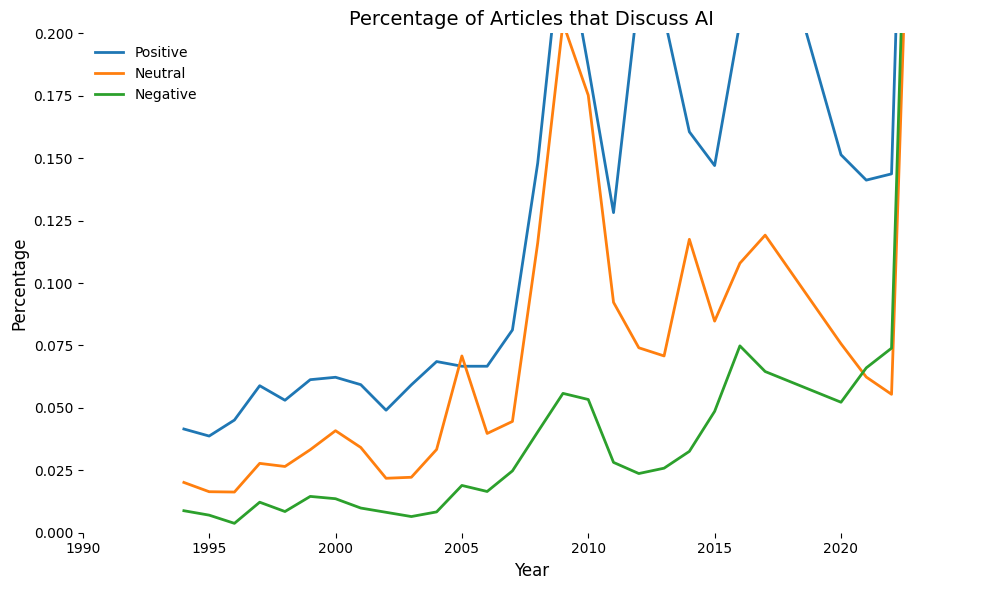

In [ ]:
valid_years = (sentiment_percentages.index >= 1994) & (sentiment_percentages.index <= 2024)
sentiment_percentages = sentiment_percentages[valid_years]

import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

# Plot three sentiment lines
plt.plot(sentiment_percentages.index, sentiment_percentages['Positive'], label='Positive', linewidth=2)
plt.plot(sentiment_percentages.index, sentiment_percentages['Neutral'], label='Neutral', linewidth=2)
plt.plot(sentiment_percentages.index, sentiment_percentages['Negative'], label='Negative', linewidth=2)

# Titles and labels
plt.title('Percentage of Articles that Discuss AI', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Percentage', fontsize=12)

# Expand Y-axis to zoom into 0–0.2
plt.ylim(0, 0.2)

# X-ticks
plt.xticks(range(1990, 2025, 5))
plt.grid(False)

# Clean legend and layout
for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.legend(frameon=False)
plt.tight_layout()

plt.show()

plt.show()


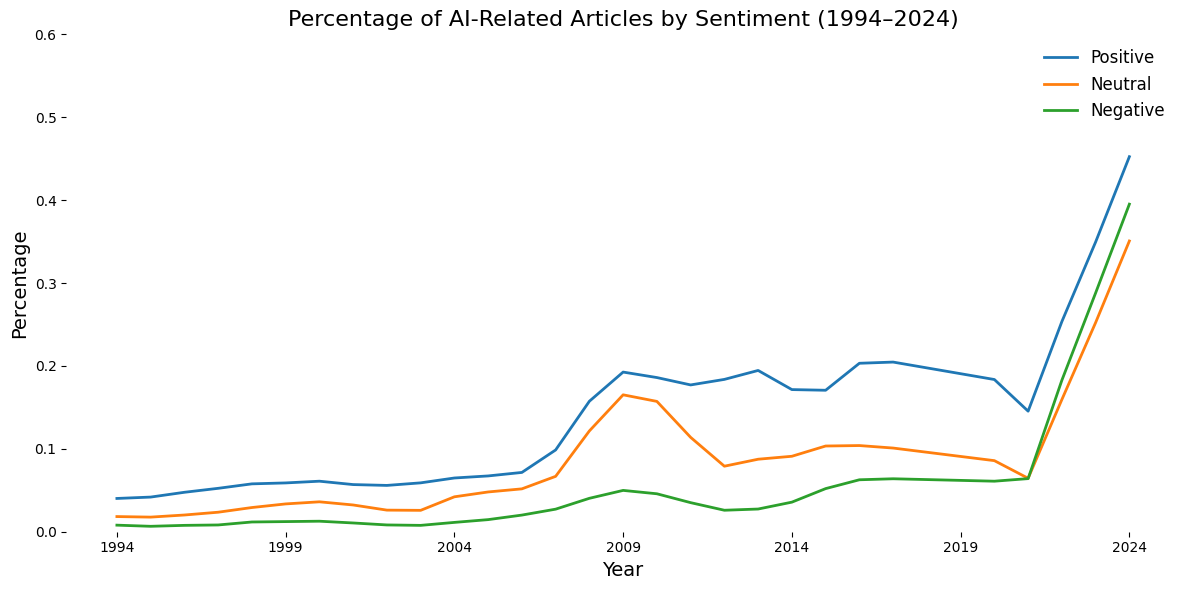

In [ ]:
import matplotlib.pyplot as plt

# Assume sentiment_percentages is already filtered to valid years
valid_years = (sentiment_percentages.index >= 1994) & (sentiment_percentages.index <= 2024)
sentiment_percentages = sentiment_percentages[valid_years]

# Optional: Smooth the lines slightly with rolling average (3-year window)
sentiment_percentages_smoothed = sentiment_percentages.rolling(window=3, center=True, min_periods=1).mean()

# Plot
plt.figure(figsize=(12,6))

plt.plot(sentiment_percentages_smoothed.index, sentiment_percentages_smoothed['Positive'], label='Positive', linewidth=2)
plt.plot(sentiment_percentages_smoothed.index, sentiment_percentages_smoothed['Neutral'], label='Neutral', linewidth=2)
plt.plot(sentiment_percentages_smoothed.index, sentiment_percentages_smoothed['Negative'], label='Negative', linewidth=2)

# Titles and labels
plt.title('Percentage of AI-Related Articles by Sentiment (1994–2024)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Percentage', fontsize=14)

# Y-axis zoom
plt.ylim(0, 0.6)

# X-ticks: Show every 5 years
plt.xticks(range(1994, 2025, 5))
plt.grid(False)

# Remove frame spines
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# Legend
plt.legend(frameon=False, fontsize=12)

# Tight layout
plt.tight_layout()

plt.show()


In [ ]:
df_keywords_filtered_classified.to_csv('/content/drive/MyDrive/thesis/data/df_keywords_sentiment.csv')

#### sentiment index for each **date**

In [ ]:
##
data_path = '/content/drive/MyDrive/thesis/data/df_keywords_sentiment.csv'
df_keywords_sentiment = pd.read_csv(data_path)
df_keywords_sentiment['pub_date'] = pd.to_datetime(df_keywords_sentiment['pub_date'])
df_keywords_sentiment['date'] = df_keywords_sentiment['pub_date'].dt.date

In [ ]:
df_keywords_sentiment.head()

,Unnamed: 0,headline,abstract,lead_paragraph,pub_date,section_name,type_of_material,web_url,keywords,year,month,text,ai_classified,sentiment,sentiment_label,date
0,0,How Q Found Her Groove,Majority of Japanese immigrants in New York Ci...,"HER arm locks like a robot's, then pops from t...",2005-01-30 05:00:00+00:00,New York,News,https://www.nytimes.com/2005/01/30/nyregion/th...,"Japan, East Village (NYC), New York City, Soci...",2005,1.0,how q found her groove majority of japanese im...,True,0.063,Positive,2005-01-30
1,1,Is I.B.M.'s Lenovo Proposal a Threat to Nation...,Committee on Foreign Investment in US is expec...,"On its face, I.B.M.'s planned sale of its pers...",2005-01-31 05:00:00+00:00,Business Day,News,https://www.nytimes.com/2005/01/31/technology/...,"China, International Business Machines Corpora...",2005,1.0,is i.b.m.'s lenovo proposal a threat to nation...,True,-0.040,Neutral,2005-01-31
2,2,Microsoft Introduces Its Own Search Service,Microsoft is introducing its homegrown search ...,Two years after saying it planned to enter the...,2005-02-01 05:00:00+00:00,Business Day,News,https://www.nytimes.com/2005/02/01/technology/...,"MSN, Microsoft Corp, Yahoo Inc, Microsoft Corp...",2005,2.0,microsoft introduces its own search service mi...,True,0.600,Positive,2005-02-01
3,3,"Google Defies Its Warning, Growing Briskly",Google says its sales and profit margins grew ...,Correction Appended,2005-02-02 05:00:00+00:00,Business Day,News,https://www.nytimes.com/2005/02/02/technology/...,"Google Inc, Sales, ADVERTISING AND MARKETING, ...",2005,2.0,"google defies its warning, growing briskly goo...",True,-0.058,Negative,2005-02-02
4,4,"Google Wants to Dominate Madison Avenue, Too","IN many ways, Larry Page and Sergey Brin seem ...","Mountain View, Calif. - IN many ways, Larry Pa...",2005-10-30 05:00:00+00:00,Business Day,News,https://www.nytimes.com/2005/10/30/business/yo...,"Google Inc, ADVERTISING, Computers and the Int...",2005,10.0,"google wants to dominate madison avenue, too i...",True,0.001,Neutral,2005-10-30


In [ ]:
# Group by date and sentiment
daily_sentiment_counts = df_keywords_sentiment.groupby(['date', 'sentiment_label']).size().unstack(fill_value=0)


In [ ]:
daily_sentiment_counts

sentiment_label,Negative,Neutral,Positive
date,,,
1994-01-06,0,0,2
1994-01-07,0,0,1
1994-01-18,0,0,1
1994-02-03,0,0,1
1994-02-18,1,0,0
...,...,...,...
2025-04-14,0,1,2
2025-04-15,0,1,2
2025-04-16,1,0,1


In [ ]:
## calculate daily sentiment balance
# Formula: (Pos - Neg) / (Pos + Neg)
daily_sentiment_index = (daily_sentiment_counts['Positive'] - daily_sentiment_counts['Negative']) / (daily_sentiment_counts['Positive'] + daily_sentiment_counts['Negative'])


In [ ]:
daily_sentiment_index

,0
date,
1994-01-06,1.000000
1994-01-07,1.000000
1994-01-18,1.000000
1994-02-03,1.000000
1994-02-18,-1.000000
...,...
2025-04-14,1.000000
2025-04-15,1.000000
2025-04-16,0.000000


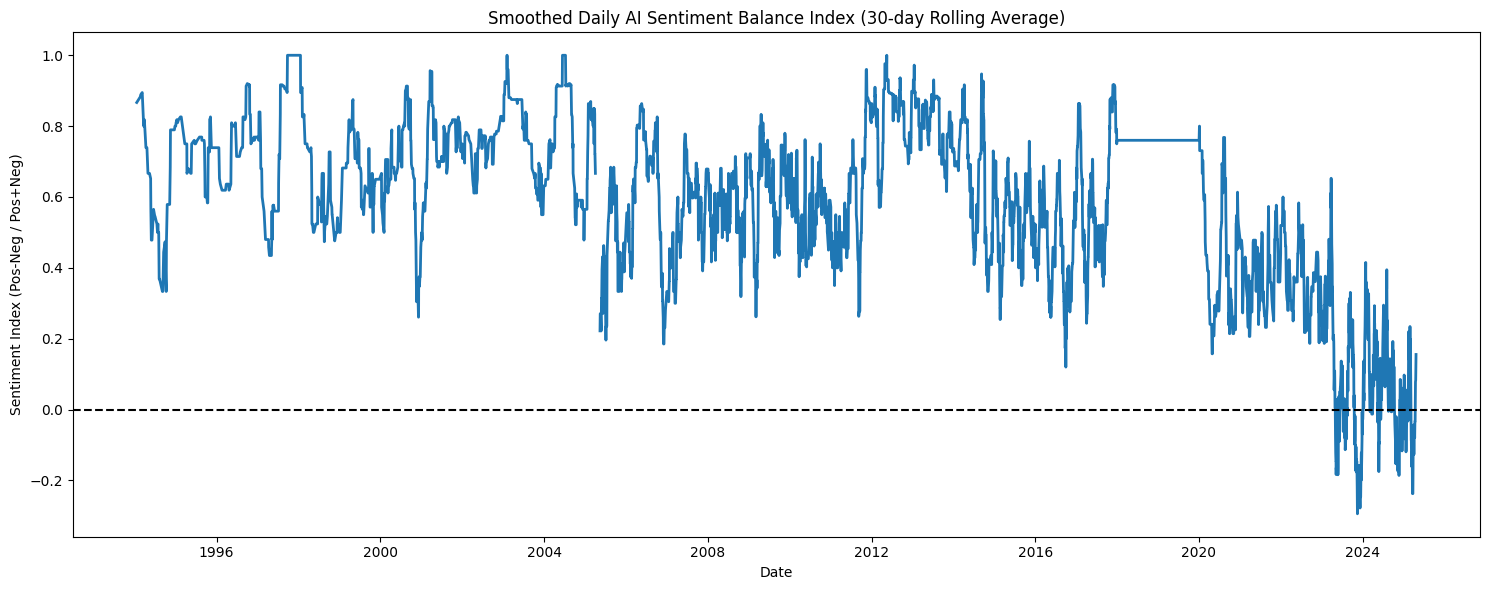

In [ ]:
import matplotlib.pyplot as plt

# Step 1: Calculate daily sentiment index (you already have this)
# daily_sentiment_index = ...

# Step 2: Apply 30-day rolling average smoothing
daily_sentiment_smoothed = daily_sentiment_index.rolling(window=30, center=True, min_periods=15).mean()

# Step 3: Plot
plt.figure(figsize=(15,6))
plt.plot(daily_sentiment_smoothed.index, daily_sentiment_smoothed.values, linewidth=2)
plt.title('Smoothed Daily AI Sentiment Balance Index (30-day Rolling Average)')
plt.xlabel('Date')
plt.ylabel('Sentiment Index (Pos-Neg / Pos+Neg)')
plt.axhline(0, color='black', linestyle='--')
plt.grid(False)
plt.tight_layout()
plt.show()


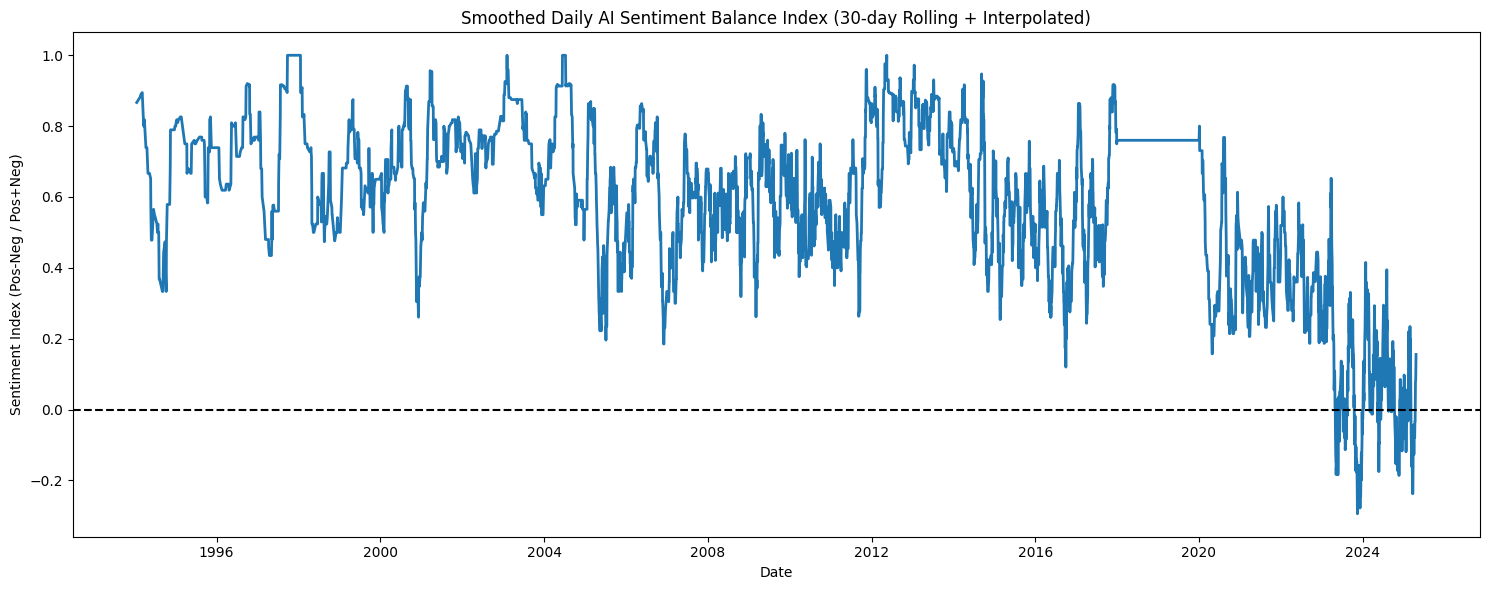

In [ ]:
# Interpolate missing points: for removing gaps
daily_sentiment_smoothed_interpolated = daily_sentiment_smoothed.interpolate(method='linear')

# Then plot
plt.figure(figsize=(15,6))
plt.plot(daily_sentiment_smoothed_interpolated.index, daily_sentiment_smoothed_interpolated.values, linewidth=2)
plt.title('Smoothed Daily AI Sentiment Balance Index (30-day Rolling + Interpolated)')
plt.xlabel('Date')
plt.ylabel('Sentiment Index (Pos-Neg / Pos+Neg)')
plt.axhline(0, color='black', linestyle='--')
plt.grid(False)
plt.tight_layout()
plt.show()


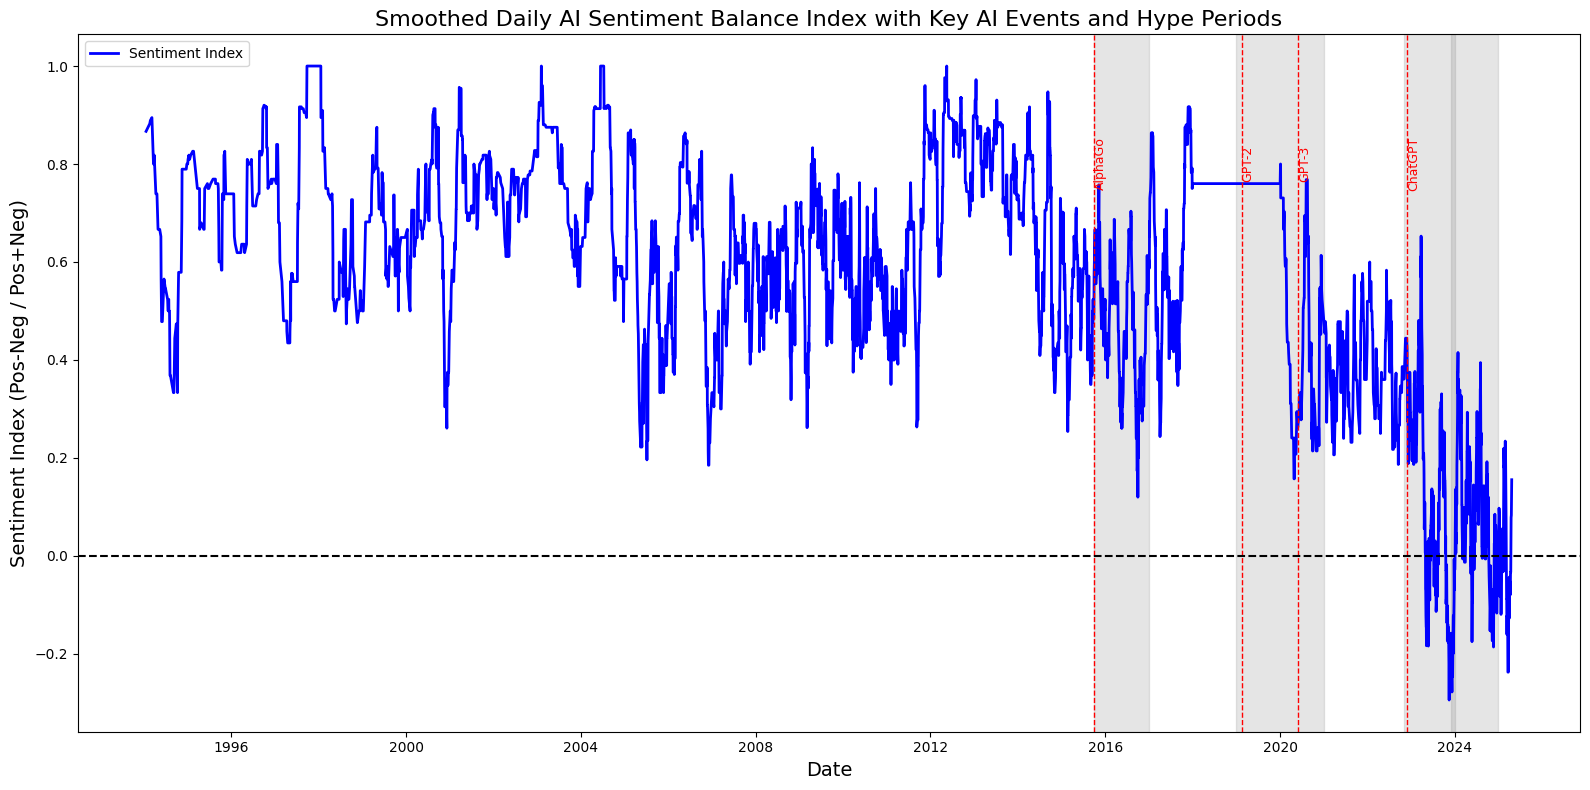

In [ ]:
import matplotlib.pyplot as plt

# Use your interpolated or forward-filled smoothed series
smoothed = daily_sentiment_smoothed_interpolated

# Set up the plot
plt.figure(figsize=(16,8))
plt.plot(smoothed.index, smoothed.values, color='blue', linewidth=2, label='Sentiment Index')

# Highlight key events with vertical lines
highlight_dates = {
    '2015-10-01': 'AlphaGo',
    '2019-02-14': 'GPT-2',
    '2020-06-01': 'GPT-3',
    '2022-11-30': 'ChatGPT'
}

for date_str, label in highlight_dates.items():
    plt.axvline(pd.to_datetime(date_str), color='red', linestyle='--', linewidth=1)
    plt.text(pd.to_datetime(date_str), 0.8, label, rotation=90, verticalalignment='center', color='red', fontsize=9)

# Shade AI hype periods
# (AlphaGo hype, GPT-2/GPT-3 buzz, ChatGPT boom)
hype_periods = [
    ('2015-10-01', '2016-12-31'),  # AlphaGo
    ('2019-01-01', '2020-12-31'),  # GPT-2/GPT-3
    ('2022-11-01', '2024-01-01'),  # ChatGPT
    ('2023-12-01', '2024-12-31')   # DeepSeek impact period (add 1 year)
]



for start_date, end_date in hype_periods:
    plt.axvspan(pd.to_datetime(start_date), pd.to_datetime(end_date), color='grey', alpha=0.2)

# Customize plot
plt.title('Smoothed Daily AI Sentiment Balance Index with Key AI Events and Hype Periods', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Sentiment Index (Pos-Neg / Pos+Neg)', fontsize=14)
plt.axhline(0, color='black', linestyle='--')
plt.legend()
plt.grid(False)
plt.tight_layout()

plt.show()


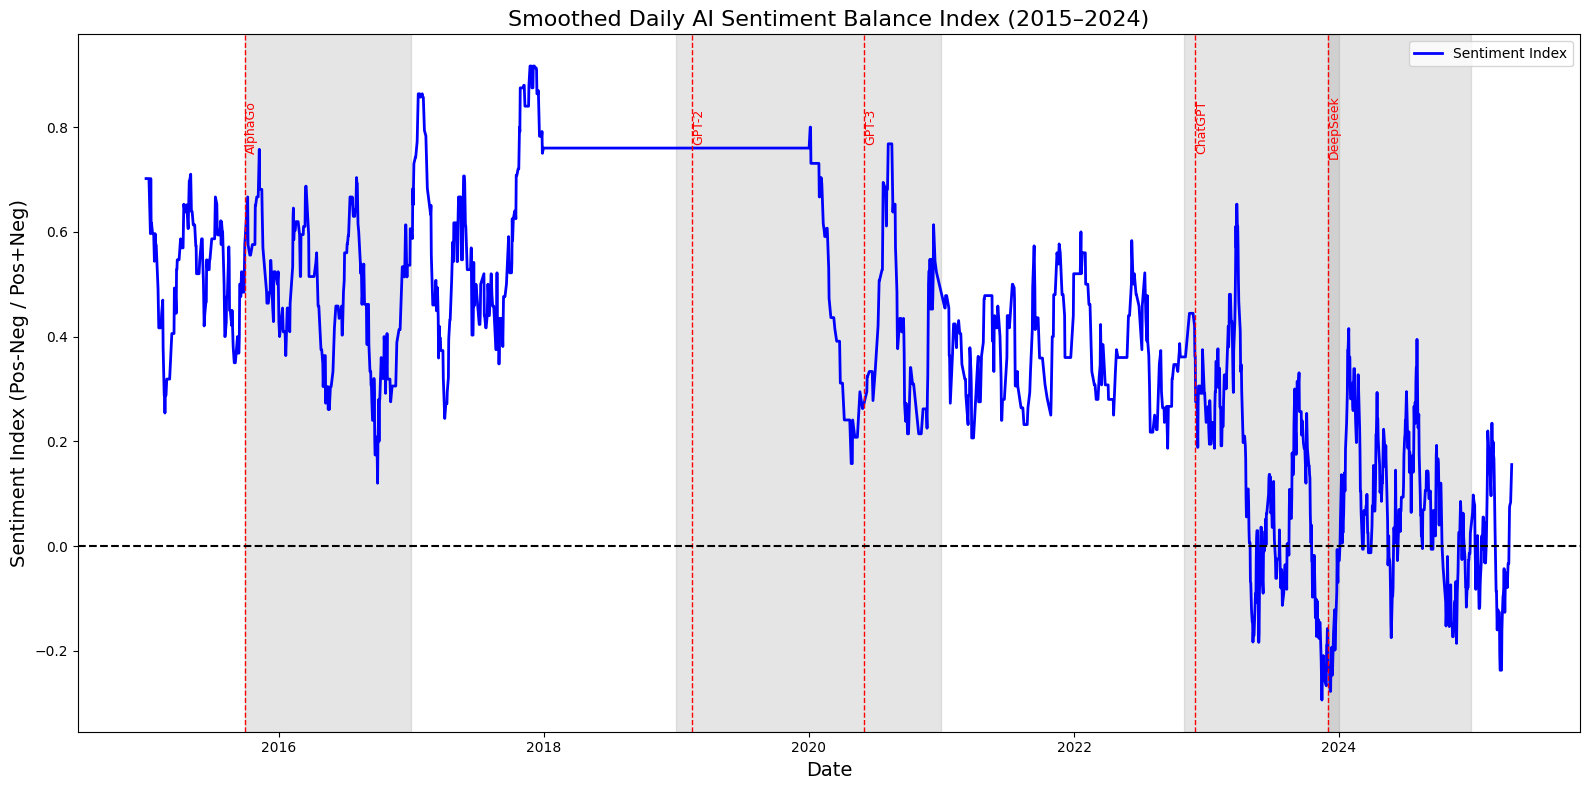

In [ ]:
import matplotlib.pyplot as plt

# Use your interpolated or forward-filled smoothed series
smoothed = daily_sentiment_smoothed_interpolated
# Filter smoothed sentiment to only keep dates from 2015 onwards
smoothed.index = pd.to_datetime(smoothed.index)
smoothed_2015 = smoothed[smoothed.index >= pd.to_datetime('2015-01-01')]



import matplotlib.pyplot as plt

plt.figure(figsize=(16,8))

# Plot only from 2015 onward
plt.plot(smoothed_2015.index, smoothed_2015.values, color='blue', linewidth=2, label='Sentiment Index')

# Highlight key AI events
highlight_dates = {
    '2015-10-01': 'AlphaGo',
    '2019-02-14': 'GPT-2',
    '2020-06-01': 'GPT-3',
    '2022-11-30': 'ChatGPT',
    '2023-12-01': 'DeepSeek'
}

for date_str, label in highlight_dates.items():
    event_date = pd.to_datetime(date_str)
    if event_date >= pd.to_datetime('2015-01-01'):
        plt.axvline(event_date, color='red', linestyle='--', linewidth=1)
        plt.text(event_date, 0.8, label, rotation=90, verticalalignment='center', color='red', fontsize=9)

# Shade hype periods (only after 2015)
hype_periods = [
    ('2015-10-01', '2016-12-31'),
    ('2019-01-01', '2020-12-31'),
    ('2022-11-01', '2024-01-01'),
    ('2023-12-01', '2024-12-31')
]

for start_date, end_date in hype_periods:
    start = pd.to_datetime(start_date)
    end = pd.to_datetime(end_date)
    if start >= pd.to_datetime('2015-01-01'):
        plt.axvspan(start, end, color='grey', alpha=0.2)

# Plot styling
plt.title('Smoothed Daily AI Sentiment Balance Index (2015–2024)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Sentiment Index (Pos-Neg / Pos+Neg)', fontsize=14)
plt.axhline(0, color='black', linestyle='--')
plt.legend()
plt.grid(False)
plt.tight_layout()

plt.show()



### Topic modeling: LDA


#### Preprocessing

In [ ]:
!pip install gensim==4.3.2 nump>=1.24.2 scipy==1.9.3 scikit-learn==1.2.2


In [ ]:
data_path = '/content/drive/MyDrive/thesis/data/df_keywords_sentiment.csv'
df_ai_classified = pd.read_csv(data_path)
df_ai_classified.head()

,Unnamed: 0,headline,abstract,lead_paragraph,pub_date,section_name,type_of_material,web_url,keywords,year,month,text,ai_classified,sentiment,sentiment_label
0,0,How Q Found Her Groove,Majority of Japanese immigrants in New York Ci...,"HER arm locks like a robot's, then pops from t...",2005-01-30 05:00:00+00:00,New York,News,https://www.nytimes.com/2005/01/30/nyregion/th...,"Japan, East Village (NYC), New York City, Soci...",2005,1.0,how q found her groove majority of japanese im...,True,0.063,Positive
1,1,Is I.B.M.'s Lenovo Proposal a Threat to Nation...,Committee on Foreign Investment in US is expec...,"On its face, I.B.M.'s planned sale of its pers...",2005-01-31 05:00:00+00:00,Business Day,News,https://www.nytimes.com/2005/01/31/technology/...,"China, International Business Machines Corpora...",2005,1.0,is i.b.m.'s lenovo proposal a threat to nation...,True,-0.040,Neutral
2,2,Microsoft Introduces Its Own Search Service,Microsoft is introducing its homegrown search ...,Two years after saying it planned to enter the...,2005-02-01 05:00:00+00:00,Business Day,News,https://www.nytimes.com/2005/02/01/technology/...,"MSN, Microsoft Corp, Yahoo Inc, Microsoft Corp...",2005,2.0,microsoft introduces its own search service mi...,True,0.600,Positive
3,3,"Google Defies Its Warning, Growing Briskly",Google says its sales and profit margins grew ...,Correction Appended,2005-02-02 05:00:00+00:00,Business Day,News,https://www.nytimes.com/2005/02/02/technology/...,"Google Inc, Sales, ADVERTISING AND MARKETING, ...",2005,2.0,"google defies its warning, growing briskly goo...",True,-0.058,Negative
4,4,"Google Wants to Dominate Madison Avenue, Too","IN many ways, Larry Page and Sergey Brin seem ...","Mountain View, Calif. - IN many ways, Larry Pa...",2005-10-30 05:00:00+00:00,Business Day,News,https://www.nytimes.com/2005/10/30/business/yo...,"Google Inc, ADVERTISING, Computers and the Int...",2005,10.0,"google wants to dominate madison avenue, too i...",True,0.001,Neutral


In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pandas as pd
import string

# Download NLTK resources
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

# Define stopwords globally (system + custom)
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()


base_stopwords = set(stopwords.words('english'))

exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

custom_stopwords = {
    # NYT junk words
    'said', 'says', 'report', 'reports', 'editor', 'writers', 'new', 'york', 'times', 'daily',
    'one', 'two', 'three', 'many', 'much', 'still', 'also', 'first', 'second', 'another', 'others',
    'including', 'according', 'recent', 'announced', 'revealed', 'today', 'year', 'years', 'day',
    'week', 'month', 'months', 'back', 'since', 'yet', 'later', 'earlier', 'former', 'current', 'future',
    'could', 'would', 'might', 'may', 'even', 'like', 'around', 'ago','people', 'american', 'america',
    'internet', 'international','yesterday,'

    # Finance/market filler
    'chief', 'executive', 'officer', 'company', 'business', 'industry', 'market', 'group', 'firm',
    'billion', 'million', 'percent', 'corporation', 'corporate', 'offices', 'services', 'products',
    'financial', 'investment', 'agency', 'insurance', 'insurer', 'deal',

    # Politics names
    'president', 'administration', 'government', 'federal', 'state', 'local', 'national', 'official',
    'trump', 'biden', 'gov', 'andrew', 'cuomo', 'california', 'china', 'chinese', 'san', 'francisco',

    # Random noise
    'photo', 'items', 'reported', 'reporters', 'greenberg', 'last', 'world', 'companies',
    'computer', 'software', 'system',
    'personal', 'operating', 'yesterday', 'computers',
    'machines', 'technology', 'online',
    'chief', 'search', 'giant', 'bonuses', 'unit',
    'web', 'executives', 'editors', 'bailout',
    'intelligence', 'artificial',  'car',
    'tech',
   'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday',

    # Finance words
    'stock', 'stocks', 'shares', 'market', 'markets', 'percent', 'billion', 'million', 'pay', 'money', 'deal', 'service', 'services',

    # Business and company lingo
    'corp', 'inc', 'company', 'firm', 'business', 'general', 'group', 'corporation',

    # Generic verbs and noise
    'based', 'using', 'use', 'found', 'make', 'made', 'help', 'called', 'aid', 'provide', 'offered', 'offers', 'offer',

    # Other NYT style noise
    'public', 'next', 'time', 'new', 'news', 'volcano', 'immigration',

    # From messy topics
    'systems', 'system', 'plan', 'plans', 'data' ,
     'sales', 'say', 'part', 'used', 'top', 'street', 'employees', 'wall',
    'big', 'interesting', 'life', 'work', 'united', 'states'

}

# Final combined stopwords set
all_stopwords = base_stopwords.union(custom_stopwords)

def preprocess(text):
    if pd.isna(text):
        return []

    # Tokenize and lowercase
    tokens = word_tokenize(text.lower())

    # Remove punctuation and non-alphabetic tokens
    tokens = [word for word in tokens if word.isalpha() and word not in exclude]

    # Remove stopwords
    tokens = [word for word in tokens if word not in all_stopwords]

    # Lemmatize
    tokens = [lemma.lemmatize(word) for word in tokens]

    # Remove very short words
    tokens = [word for word in tokens if len(word) > 2]

    return tokens


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
df_ai_classified['tokens'] = df_ai_classified['text'].apply(preprocess)


In [ ]:
df_ai_classified.head()

,Unnamed: 0,headline,abstract,lead_paragraph,pub_date,section_name,type_of_material,web_url,keywords,year,month,text,ai_classified,sentiment,sentiment_label,tokens
0,0,How Q Found Her Groove,Majority of Japanese immigrants in New York Ci...,"HER arm locks like a robot's, then pops from t...",2005-01-30 05:00:00+00:00,New York,News,https://www.nytimes.com/2005/01/30/nyregion/th...,"Japan, East Village (NYC), New York City, Soci...",2005,1.0,how q found her groove majority of japanese im...,True,0.063,Positive,"[groove, majority, japanese, immigrant, city, ..."
1,1,Is I.B.M.'s Lenovo Proposal a Threat to Nation...,Committee on Foreign Investment in US is expec...,"On its face, I.B.M.'s planned sale of its pers...",2005-01-31 05:00:00+00:00,Business Day,News,https://www.nytimes.com/2005/01/31/technology/...,"China, International Business Machines Corpora...",2005,1.0,is i.b.m.'s lenovo proposal a threat to nation...,True,-0.040,Neutral,"[lenovo, proposal, threat, security, committee..."
2,2,Microsoft Introduces Its Own Search Service,Microsoft is introducing its homegrown search ...,Two years after saying it planned to enter the...,2005-02-01 05:00:00+00:00,Business Day,News,https://www.nytimes.com/2005/02/01/technology/...,"MSN, Microsoft Corp, Yahoo Inc, Microsoft Corp...",2005,2.0,microsoft introduces its own search service mi...,True,0.600,Positive,"[microsoft, introduces, microsoft, introducing..."
3,3,"Google Defies Its Warning, Growing Briskly",Google says its sales and profit margins grew ...,Correction Appended,2005-02-02 05:00:00+00:00,Business Day,News,https://www.nytimes.com/2005/02/02/technology/...,"Google Inc, Sales, ADVERTISING AND MARKETING, ...",2005,2.0,"google defies its warning, growing briskly goo...",True,-0.058,Negative,"[google, defies, warning, growing, briskly, go..."
4,4,"Google Wants to Dominate Madison Avenue, Too","IN many ways, Larry Page and Sergey Brin seem ...","Mountain View, Calif. - IN many ways, Larry Pa...",2005-10-30 05:00:00+00:00,Business Day,News,https://www.nytimes.com/2005/10/30/business/yo...,"Google Inc, ADVERTISING, Computers and the Int...",2005,10.0,"google wants to dominate madison avenue, too i...",True,0.001,Neutral,"[google, want, dominate, madison, avenue, way,..."


In [ ]:
df_ai_classified.to_csv('/content/drive/MyDrive/thesis/data/df_tokens.csv', index=False)

In [ ]:
df_tokens = pd.read_csv('/content/drive/MyDrive/thesis/data/df_tokens.csv')
df_tokens.head()

,Unnamed: 0,headline,abstract,lead_paragraph,pub_date,section_name,type_of_material,web_url,keywords,year,month,text,ai_classified,sentiment,sentiment_label,tokens
0,0,How Q Found Her Groove,Majority of Japanese immigrants in New York Ci...,"HER arm locks like a robot's, then pops from t...",2005-01-30 05:00:00+00:00,New York,News,https://www.nytimes.com/2005/01/30/nyregion/th...,"Japan, East Village (NYC), New York City, Soci...",2005,1.0,how q found her groove majority of japanese im...,True,0.063,Positive,"['groove', 'majority', 'japanese', 'immigrant'..."
1,1,Is I.B.M.'s Lenovo Proposal a Threat to Nation...,Committee on Foreign Investment in US is expec...,"On its face, I.B.M.'s planned sale of its pers...",2005-01-31 05:00:00+00:00,Business Day,News,https://www.nytimes.com/2005/01/31/technology/...,"China, International Business Machines Corpora...",2005,1.0,is i.b.m.'s lenovo proposal a threat to nation...,True,-0.040,Neutral,"['lenovo', 'proposal', 'threat', 'security', '..."
2,2,Microsoft Introduces Its Own Search Service,Microsoft is introducing its homegrown search ...,Two years after saying it planned to enter the...,2005-02-01 05:00:00+00:00,Business Day,News,https://www.nytimes.com/2005/02/01/technology/...,"MSN, Microsoft Corp, Yahoo Inc, Microsoft Corp...",2005,2.0,microsoft introduces its own search service mi...,True,0.600,Positive,"['microsoft', 'introduces', 'microsoft', 'intr..."
3,3,"Google Defies Its Warning, Growing Briskly",Google says its sales and profit margins grew ...,Correction Appended,2005-02-02 05:00:00+00:00,Business Day,News,https://www.nytimes.com/2005/02/02/technology/...,"Google Inc, Sales, ADVERTISING AND MARKETING, ...",2005,2.0,"google defies its warning, growing briskly goo...",True,-0.058,Negative,"['google', 'defies', 'warning', 'growing', 'br..."
4,4,"Google Wants to Dominate Madison Avenue, Too","IN many ways, Larry Page and Sergey Brin seem ...","Mountain View, Calif. - IN many ways, Larry Pa...",2005-10-30 05:00:00+00:00,Business Day,News,https://www.nytimes.com/2005/10/30/business/yo...,"Google Inc, ADVERTISING, Computers and the Int...",2005,10.0,"google wants to dominate madison avenue, too i...",True,0.001,Neutral,"['google', 'want', 'dominate', 'madison', 'ave..."


In [ ]:
from gensim import corpora

# Create a dictionary
dictionary = corpora.Dictionary(df_ai_classified['tokens'])

# Create a bag-of-words corpus
corpus = [dictionary.doc2bow(tokens) for tokens in df_ai_classified['tokens']]


#### Load LDA model

In [ ]:
from gensim.models import LdaModel

In [ ]:


# Train LDA model
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=5,    # Change number of topics if you want more/fewer
    random_state=100,
    passes=15,       # How many passes over corpus
    per_word_topics=True
)

#### find the optimal number of topics

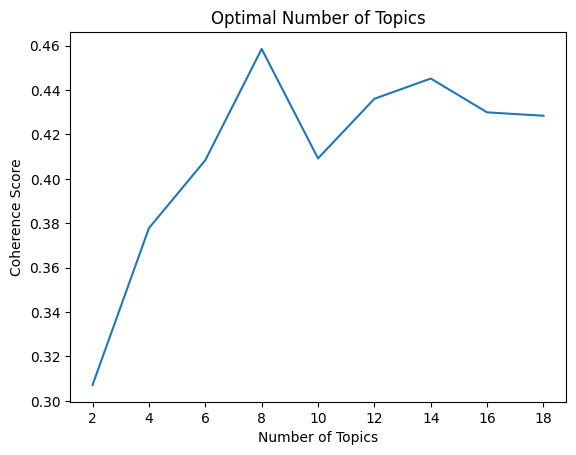

In [ ]:
from gensim.models import CoherenceModel

# Define function to compute coherence for different topic numbers
def compute_coherence_values(dictionary, corpus, texts, start=2, limit=20, step=2):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=100, passes=15)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

# Run coherence score search
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=df_ai_classified['tokens'], start=2, limit=20, step=2)

# Plot coherence score
import matplotlib.pyplot as plt

x = range(2, 20, 2)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Optimal Number of Topics")
plt.show()


#### Retrain lDA with 8 topic

In [ ]:

# Retrain final model
lda_model_8 = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=8,  # final choice
    random_state=42,
    chunksize=1000,
    passes=10,  # 🔥 now use higher passes for quality
    alpha='auto'
)

In [ ]:
lda_model_8.save("/content/drive/MyDrive/thesis/model/lda_model_8.gensim")

In [ ]:
from gensim.models import LdaModel

lda_model_8 = LdaModel.load("/content/drive/MyDrive/thesis/model/lda_model_8.gensim")

In [ ]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model_8, corpus, dictionary)
vis


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_sputils.py:44: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  upcast = np.find_common_type(args, [])


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.169652 -0.030982       1        1  29.534929
7      0.215713  0.050093       2        1  17.079765
6     -0.106707 -0.179370       3        1  12.358715
1     -0.157200 -0.008824       4        1  10.760044
0     -0.220243  0.230417       5        1  10.634196
4      0.143008  0.130525       6        1   8.328812
3     -0.010142 -0.022299       7        1   5.686966
5     -0.034081 -0.169561       8        1   5.616573, topic_info=           Term         Freq        Total Category  logprob  loglift
109      google  3773.000000  3773.000000  Default  30.0000  30.0000
35        robot  1219.000000  1219.000000  Default  29.0000  29.0000
93    microsoft  1105.000000  1105.000000  Default  28.0000  28.0000
450       apple   962.000000   962.000000  Default  27.0000  27.0000
552      amazon   620.000000   620.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
1189       deep    39.316994    86.239132   Topic8  -5.8423   2.0940
1040    digital    44.115245   233.720481   Topic8  -5.7271   1.2121
950      nearly    38.483688   193.155405   Topic8  -5.8637   1.2662
691     version    38.011675   205.032343   Topic8  -5.8760   1.1942
587      player    37.639954   110.930798   Topic8  -5.8859   1.7986

[483 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
604       4  0.986255      accused
778       3  0.991307      acquire
2131      1  0.009808     acquired
2131      3  0.990657     acquired
994       1  0.026528  acquisition
...     ...       ...          ...
99        1  0.316207        yahoo
99        3  0.677586        yahoo
418       1  0.976013      youtube
418       3  0.016828      youtube
1378      8  0.985950   zuckerberg

[895 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 8, 7, 2, 1, 5, 4, 6])

In [ ]:
topics = lda_model_8.print_topics(num_words=5)
for i, topic in topics:
    print(f"Topic #{i+1}: {topic}")

Topic #1: 0.016*"bank" + 0.010*"reserve" + 0.009*"maurice" + 0.009*"loss" + 0.008*"treasury"
Topic #2: 0.006*"familiar" + 0.006*"investor" + 0.006*"house" + 0.006*"robert" + 0.005*"benmosche"
Topic #3: 0.052*"google" + 0.012*"facebook" + 0.007*"user" + 0.005*"site" + 0.005*"way"
Topic #4: 0.012*"profit" + 0.009*"quarter" + 0.009*"tesla" + 0.009*"nvidia" + 0.007*"earnings"
Topic #5: 0.033*"apple" + 0.030*"amazon" + 0.012*"voice" + 0.011*"iphone" + 0.010*"openai"
Topic #6: 0.038*"microsoft" + 0.011*"game" + 0.010*"bonus" + 0.007*"video" + 0.007*"travel"
Topic #7: 0.016*"buy" + 0.013*"microsoft" + 0.009*"scuttlebot" + 0.009*"offering" + 0.008*"ibm"
Topic #8: 0.030*"robot" + 0.010*"human" + 0.008*"car" + 0.006*"city" + 0.005*"recognition"


In [ ]:
lda_model_8.save("lda_model_8.gensim")

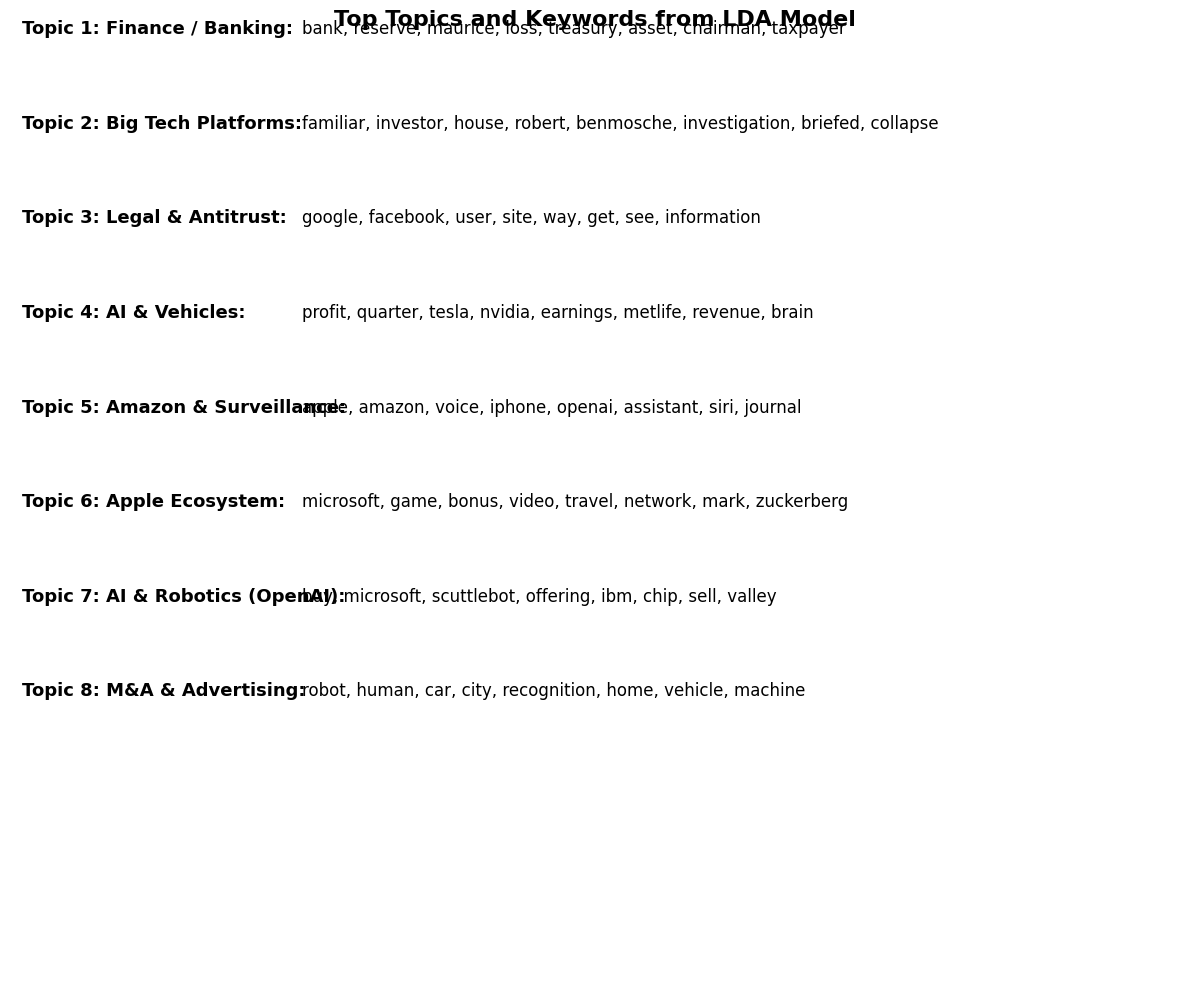

In [ ]:
import matplotlib.pyplot as plt

# Define custom labels for each topic (manually assigned based on keyword inspection)
custom_labels = {
    0: "Finance / Banking",
    1: "Big Tech Platforms",
    2: "Legal & Antitrust",
    3: "AI & Vehicles",
    4: "Amazon & Surveillance",
    5: "Apple Ecosystem",
    6: "AI & Robotics (OpenAI)",
    7: "M&A & Advertising"
}

# Extract top keywords from each topic
topics = {}
for i in range(8):
    label = f"Topic {i+1}: {custom_labels.get(i, f'Topic {i+1}')}"
    terms = lda_model_8.show_topic(i, topn=8)
    keywords = [term for term, weight in terms]
    topics[label] = keywords

# Plotting
plt.figure(figsize=(12, 10))
plt.title("Top Topics and Keywords from LDA Model", fontsize=16, weight='bold')
plt.axis('off')

y = 1.0
line_height = 0.1
for topic_label, keywords in topics.items():
    plt.text(0.01, y, f"{topic_label}:", fontsize=13, weight='bold')
    plt.text(0.25, y, ", ".join(keywords), fontsize=12)
    y -= line_height

plt.tight_layout()
plt.show()


### NER Extraction (Organization / Person / Country) with Post-Filtering

In [ ]:
!pip install spacy
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 44.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import spacy

# Load English model
nlp = spacy.load('en_core_web_sm')

In [ ]:
# Clean extraction function
def extract_entities(text):
    if pd.isna(text):
        return [], [], []
    doc = nlp(text)
    people = [ent.text for ent in doc.ents if ent.label_ == "PERSON"]
    organizations = [ent.text for ent in doc.ents if ent.label_ == "ORG"]
    countries = [ent.text for ent in doc.ents if ent.label_ in ["GPE", "LOC"]]
    return people, organizations, countries


df_keywords_sentiment = pd.read_csv('/content/drive/MyDrive/thesis/data/df_tokens_1.csv')


# Create new columns for entities
df_keywords_sentiment[['people', 'organizations', 'countries']] = df_keywords_sentiment['text'].apply(
    lambda x: pd.Series(extract_entities(x))
)


In [ ]:
# Define AI-related organizations
ai_related_orgs = [
    'openai', 'google', 'deepmind', 'meta', 'facebook', 'microsoft', 'amazon', 'anthropic',
    'ibm', 'nvidia', 'apple', 'baidu', 'alibaba', 'tesla', 'stability ai', 'hugging face', 'cohere',
    'midjourney', 'adobe', 'palantir'
]

# Smart filtering function
def filter_ai_orgs(org_list, ai_list):
    return [org for org in org_list if any(ai_name in org.lower() for ai_name in ai_list)]

# Apply filtering
df_keywords_sentiment['ai_organizations'] = df_keywords_sentiment['organizations'].apply(
    lambda x: filter_ai_orgs(x, ai_related_orgs) if isinstance(x, list) else []
)


In [ ]:
name_mapping = {
    'apple': 'Apple',
    'apple.com': 'Apple',
    'apple computer inc.': 'Apple',
    "apple computer inc.'s": 'Apple',
    "apple’s": 'Apple',
    'apple computer inc': 'Apple',
    "apple computer inc's": 'Apple',
    'apple valley inc': 'Apple',
    'apple valley inc.': 'Apple',
    'apple mobile': 'Apple',
    'apple san francisco': 'Apple',
    'apple inc': 'Apple',
    'apple inc.': 'Apple',
    'amazon.com': 'Amazon',
    'amazon.com': 'Amazon',
    'amazon': 'Amazon',
    'amazon.com': 'Amazon',
    'amazon echo': 'Amazon',
    'amazon web services': 'Amazon',
    'amazon web services inc.': 'Amazon',
    'amazon web services inc': 'Amazon',
    'amazon.com inc': 'Amazon',
    'baidu': 'Baidu',
    'microsoft': 'Microsoft',
    'microsoft corp': 'Microsoft',
    "microsoft corporation's": 'Microsoft',
    'microsoft corporation': 'Microsoft',
    'microsoft’s': 'Microsoft',
    'microsoft office': 'Microsoft',
    'the microsoft corporation': 'Microsoft',
    'yahoo-microsoft': 'Microsoft',
    'microsoft-google': 'Microsoft',
    'microsoft research': 'Microsoft',
    "microsoft corp's": 'Microsoft',
    'microsoft nt': 'Microsoft',
    "the microsoft corporation's": 'Microsoft',
    'gestures microsoft': 'Microsoft',
    'meta': 'Meta',
    'meta’s': 'Meta',
    'google': 'Google',
    'google voice': 'Google',
    'google inc.': 'Google',
    'google home': 'Google',
    'google tv': 'Google',
    'google.org': 'Google',
    'alibaba': 'Alibaba',
    'alibaba.com': 'Alibaba',

    'nvidia': 'Nvidia',
    'nvidia.': 'Nvidia',
    'nvidia corporation': 'Nvidia',
    'nvidia corporation.': 'Nvidia',
    'nvidia corporation’s': 'Nvidia',
    'meta': 'Meta',
    'meta’s': 'Meta',
    'metatools inc.': 'Meta',
    'meta research': 'Meta',
    'meta research inc.': 'Meta',
    'adobe systems inc.': 'Adobe',
    'adobe': 'Adobe',

    'ibm': 'IBM',
    'ibm de mexico': 'IBM',
    'ibm canada ltd.': 'IBM',
    "ibm corp's": 'IBM',
    'ibm research': 'IBM',
    'ibm research inc.': 'IBM'
}


In [ ]:
from collections import Counter

# Flatten list of all organizations
all_orgs = sum(df_keywords_sentiment['ai_organizations'].dropna().tolist(), [])

# Map each org name to its standardized name
all_orgs_mapped = [name_mapping.get(org.lower(), org) for org in all_orgs]

# Count
org_counter = Counter(all_orgs_mapped)
top_10_orgs = org_counter.most_common(10)

print(top_10_orgs)


[('Google', 1705), ('Microsoft', 1099), ('IBM', 703), ('Apple', 322), ('Amazon', 227), ('Nvidia', 25), ('Meta', 19), ('Alibaba', 12), ('Adobe', 5), ('Baidu', 4)]


####  Top 10 AI Organizations Mentioned (Bar Chart)

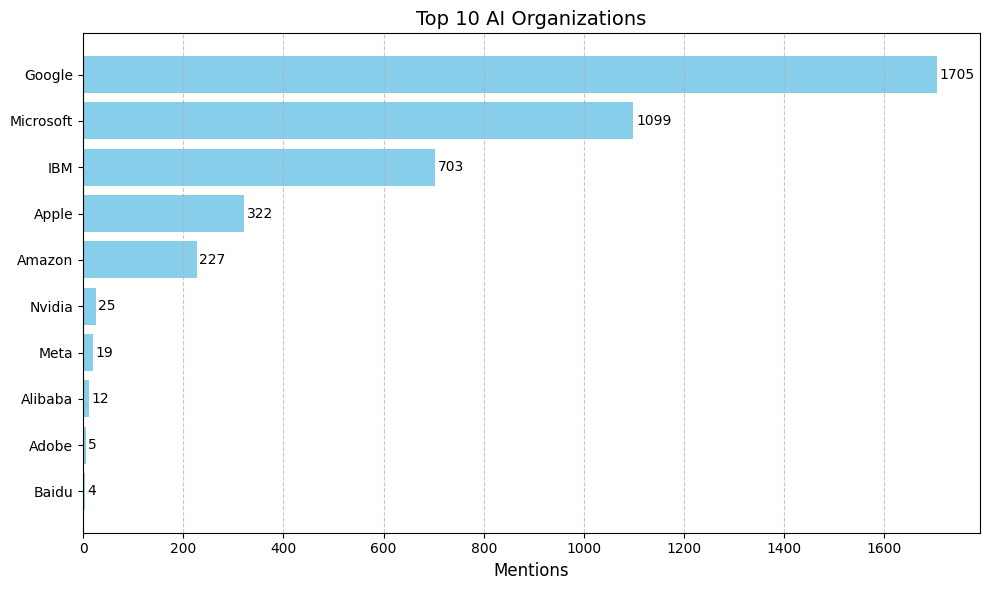

In [ ]:
import matplotlib.pyplot as plt

# Unpack names and counts correctly
org_names, counts = zip(*top_10_orgs)

# Create the plot
plt.figure(figsize=(10, 6))
bars = plt.barh(org_names, counts, color='skyblue')
plt.gca().invert_yaxis()  # Highest count at the top
plt.title('Top 10 AI Organizations', fontsize=14)
plt.xlabel('Mentions', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add counts on bars
for bar in bars:
    plt.text(
        bar.get_width() + 5,                   # X position: little to the right of the bar
        bar.get_y() + bar.get_height() / 2,     # Y position: center of the bar
        f'{int(bar.get_width())}',              # The actual count number
        va='center',                            # Vertical align center
        fontsize=10
    )

plt.tight_layout()
plt.show()


#### 10 keywords for each decade

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/thesis/data/df_tokens.csv')
# Make sure pub_date is parsed
df['pub_date'] = pd.to_datetime(df['pub_date'])


# Create decade column
df['decade'] = (df['pub_date'].dt.year // 10) * 10


In [ ]:
df.head()

,Unnamed: 0,headline,abstract,lead_paragraph,pub_date,section_name,type_of_material,web_url,keywords,year,month,text,ai_classified,sentiment,sentiment_label,decade,tokens,window
0,0,How Q Found Her Groove,Majority of Japanese immigrants in New York Ci...,"HER arm locks like a robot's, then pops from t...",2005-01-30 05:00:00+00:00,New York,News,https://www.nytimes.com/2005/01/30/nyregion/th...,"Japan, East Village (NYC), New York City, Soci...",2005,1.0,how q found her groove majority of japanese im...,True,0.063,Positive,2000,"['found', 'groove', 'majority', 'japanese', 'i...",2005
1,1,Is I.B.M.'s Lenovo Proposal a Threat to Nation...,Committee on Foreign Investment in US is expec...,"On its face, I.B.M.'s planned sale of its pers...",2005-01-31 05:00:00+00:00,Business Day,News,https://www.nytimes.com/2005/01/31/technology/...,"China, International Business Machines Corpora...",2005,1.0,is i.b.m.'s lenovo proposal a threat to nation...,True,-0.040,Neutral,2000,"['lenovo', 'proposal', 'threat', 'security', '...",2005
2,2,Microsoft Introduces Its Own Search Service,Microsoft is introducing its homegrown search ...,Two years after saying it planned to enter the...,2005-02-01 05:00:00+00:00,Business Day,News,https://www.nytimes.com/2005/02/01/technology/...,"MSN, Microsoft Corp, Yahoo Inc, Microsoft Corp...",2005,2.0,microsoft introduces its own search service mi...,True,0.600,Positive,2000,"['microsoft', 'introduces', 'search', 'service...",2005
3,3,"Google Defies Its Warning, Growing Briskly",Google says its sales and profit margins grew ...,Correction Appended,2005-02-02 05:00:00+00:00,Business Day,News,https://www.nytimes.com/2005/02/02/technology/...,"Google Inc, Sales, ADVERTISING AND MARKETING, ...",2005,2.0,"google defies its warning, growing briskly goo...",True,-0.058,Negative,2000,"['google', 'defies', 'warning', 'growing', 'br...",2005
4,4,"Google Wants to Dominate Madison Avenue, Too","IN many ways, Larry Page and Sergey Brin seem ...","Mountain View, Calif. - IN many ways, Larry Pa...",2005-10-30 05:00:00+00:00,Business Day,News,https://www.nytimes.com/2005/10/30/business/yo...,"Google Inc, ADVERTISING, Computers and the Int...",2005,10.0,"google wants to dominate madison avenue, too i...",True,0.001,Neutral,2000,"['google', 'wants', 'dominate', 'madison', 'av...",2005


In [ ]:
from collections import Counter

# Group tokens by decade
decade_keywords = {}

for decade, group in df_tokens.groupby('decade'):
    all_tokens = [token for tokens in group['tokens'] for token in tokens]
    counter = Counter(all_tokens)
    top_10 = counter.most_common(10)
    decade_keywords[decade] = top_10

# Display
for decade in sorted(decade_keywords.keys()):
    print(f"\nTop Keywords for {decade}s:")
    for word, freq in decade_keywords[decade]:
        print(f"{word}: {freq}")



Top Keywords for 1990s:
computer: 528
software: 296
microsoft: 281
apple: 268
ibm: 251
computers: 226
yesterday: 193
international: 174
system: 163
machines: 158

Top Keywords for 2000s:
google: 1432
american: 1378
international: 1355
microsoft: 654
software: 447
search: 446
last: 355
ibm: 350
computer: 339
unit: 322

Top Keywords for 2010s:
google: 1446
american: 647
international: 599
facebook: 430
web: 418
apple: 415
amazon: 335
robot: 334
search: 301
intelligence: 260

Top Keywords for 2020s:
artificial: 1061
intelligence: 1054
openai: 465
google: 390
tech: 380
chatgpt: 277
world: 242
companies: 233
chatbot: 227
musk: 226


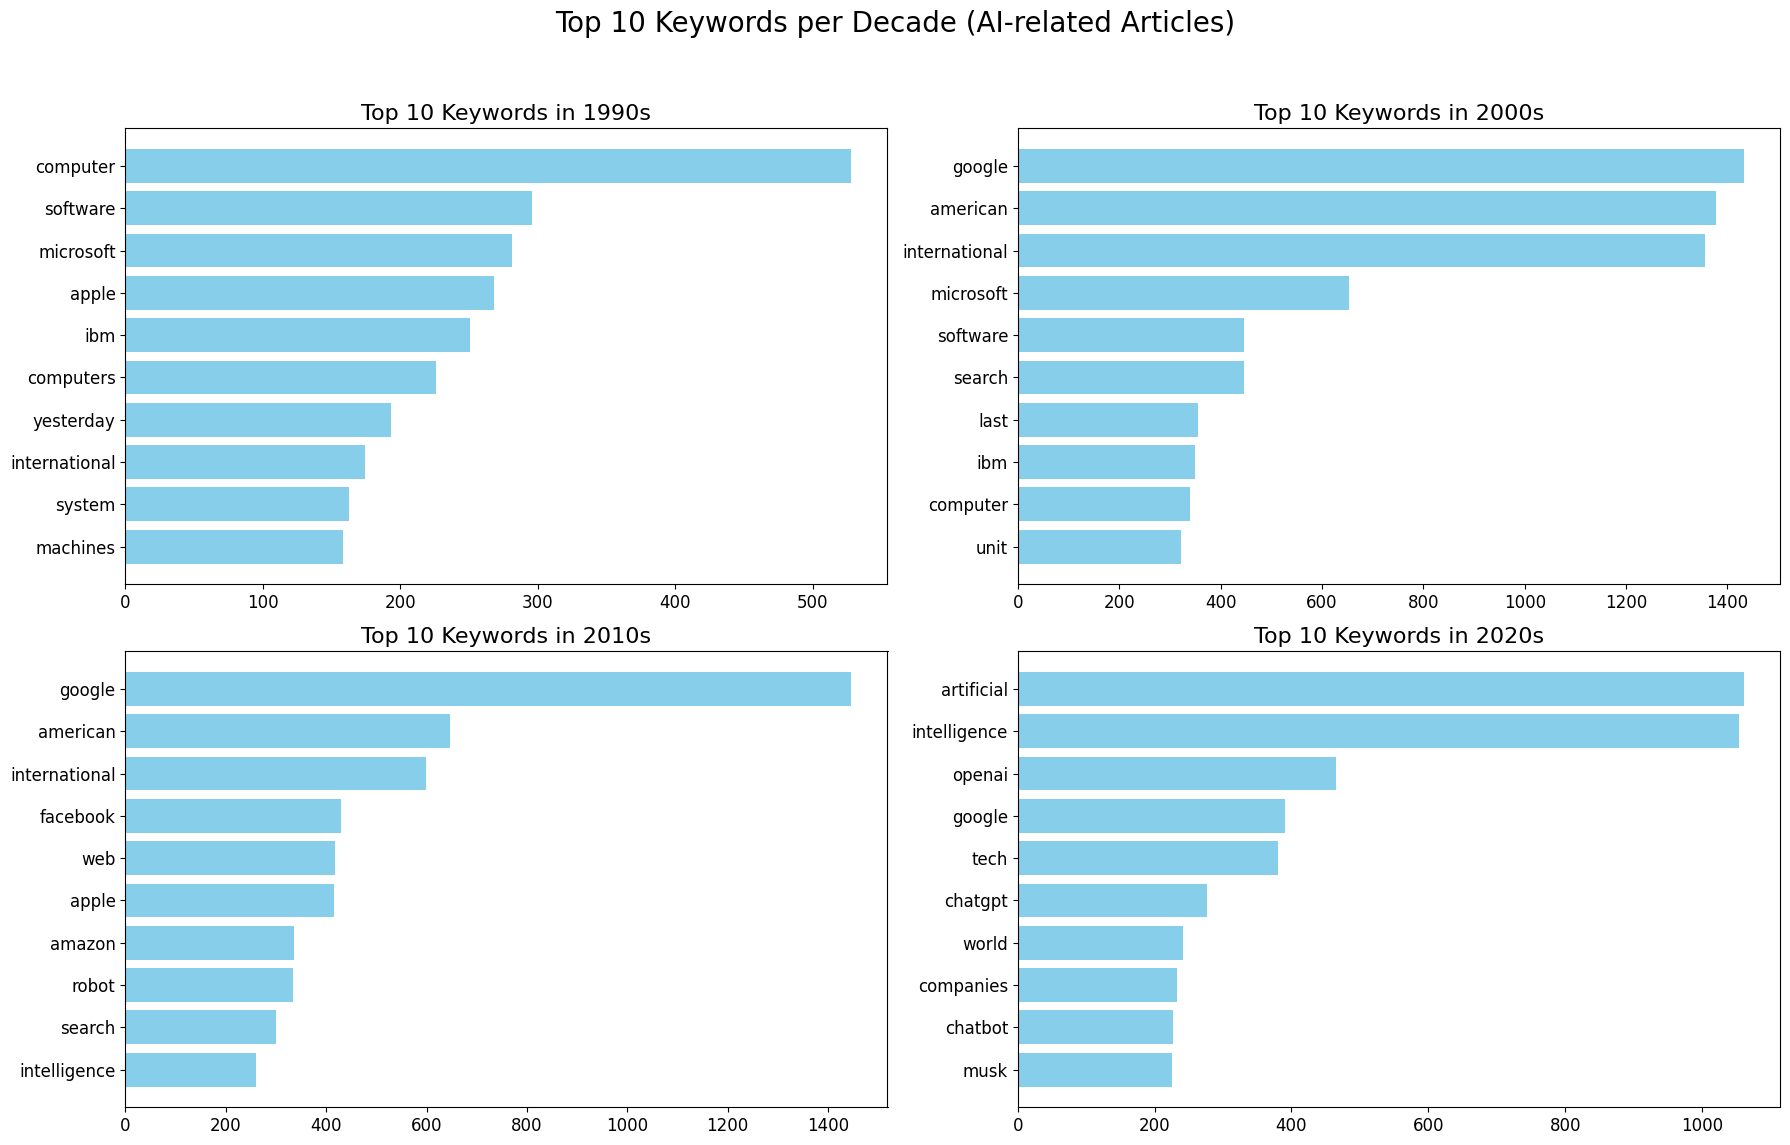

In [ ]:
import matplotlib.pyplot as plt

# Set up subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()

decades_sorted = sorted(decade_keywords.keys())

for idx, decade in enumerate(decades_sorted):
    keywords, counts = zip(*decade_keywords[decade])

    axes[idx].barh(keywords, counts, color='skyblue')
    axes[idx].set_title(f"Top 10 Keywords in {decade}s", fontsize=16)
    axes[idx].invert_yaxis()  # Highest count on top
    axes[idx].tick_params(axis='both', which='major', labelsize=12)

# Adjust layout
plt.suptitle('Top 10 Keywords per Decade (AI-related Articles)', fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


#### keywords for 5 year window

##### Preprocess for df_tokens

In [ ]:
import nltk
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter

# Download required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/thesis/data/df_keywords_sentiment.csv')
# Make sure pub_date is parsed
df['pub_date'] = pd.to_datetime(df['pub_date'])

In [ ]:
# Fix year and window
df['year'] = df['pub_date'].dt.year

def get_5yr_window(year):
    return (year // 5) * 5

df['window'] = df['year'].apply(get_5yr_window)



In [ ]:
df.head()


,Unnamed: 0,headline,abstract,lead_paragraph,pub_date,section_name,type_of_material,web_url,keywords,year,month,text,ai_classified,sentiment,sentiment_label,window
0,0,How Q Found Her Groove,Majority of Japanese immigrants in New York Ci...,"HER arm locks like a robot's, then pops from t...",2005-01-30 05:00:00+00:00,New York,News,https://www.nytimes.com/2005/01/30/nyregion/th...,"Japan, East Village (NYC), New York City, Soci...",2005,1.0,how q found her groove majority of japanese im...,True,0.063,Positive,2005
1,1,Is I.B.M.'s Lenovo Proposal a Threat to Nation...,Committee on Foreign Investment in US is expec...,"On its face, I.B.M.'s planned sale of its pers...",2005-01-31 05:00:00+00:00,Business Day,News,https://www.nytimes.com/2005/01/31/technology/...,"China, International Business Machines Corpora...",2005,1.0,is i.b.m.'s lenovo proposal a threat to nation...,True,-0.040,Neutral,2005
2,2,Microsoft Introduces Its Own Search Service,Microsoft is introducing its homegrown search ...,Two years after saying it planned to enter the...,2005-02-01 05:00:00+00:00,Business Day,News,https://www.nytimes.com/2005/02/01/technology/...,"MSN, Microsoft Corp, Yahoo Inc, Microsoft Corp...",2005,2.0,microsoft introduces its own search service mi...,True,0.600,Positive,2005
3,3,"Google Defies Its Warning, Growing Briskly",Google says its sales and profit margins grew ...,Correction Appended,2005-02-02 05:00:00+00:00,Business Day,News,https://www.nytimes.com/2005/02/02/technology/...,"Google Inc, Sales, ADVERTISING AND MARKETING, ...",2005,2.0,"google defies its warning, growing briskly goo...",True,-0.058,Negative,2005
4,4,"Google Wants to Dominate Madison Avenue, Too","IN many ways, Larry Page and Sergey Brin seem ...","Mountain View, Calif. - IN many ways, Larry Pa...",2005-10-30 05:00:00+00:00,Business Day,News,https://www.nytimes.com/2005/10/30/business/yo...,"Google Inc, ADVERTISING, Computers and the Int...",2005,10.0,"google wants to dominate madison avenue, too i...",True,0.001,Neutral,2005


In [ ]:
# Base English stopwords
base_stopwords = set(stopwords.words('english'))

# Custom stopwords to remove filler, political, and finance words
custom_stopwords = {
    # NYT junk words
    'said', 'says', 'report', 'reports', 'editor', 'writers', 'new', 'york', 'times', 'daily',
    'one', 'two', 'three', 'many', 'much', 'still', 'also', 'first', 'second', 'another', 'others',
    'including', 'according', 'recent', 'announced', 'revealed', 'today', 'year', 'years', 'day',
    'week', 'month', 'months', 'back', 'since', 'yet', 'later', 'earlier', 'former', 'current', 'future',
    'could', 'would', 'might', 'may', 'even', 'like', 'around', 'ago','people', 'american', 'america',
    'internet', 'international','yesterday,'

    # Finance/market filler
    'chief', 'executive', 'officer', 'company', 'business', 'industry', 'market', 'group', 'firm',
    'billion', 'million', 'percent', 'corporation', 'corporate', 'offices', 'services', 'products',
    'financial', 'investment', 'agency', 'insurance', 'insurer', 'deal',

    # Politics names
    'president', 'administration', 'government', 'federal', 'state', 'local', 'national', 'official',
    'trump', 'biden', 'gov', 'andrew', 'cuomo', 'california', 'china', 'chinese', 'san', 'francisco',

    # Random noise
    'photo', 'items', 'reported', 'reporters', 'greenberg', 'last', 'world', 'companies',
    'computer', 'software', 'system',
    'personal', 'operating', 'yesterday', 'computers',
    'machines', 'technology', 'online',
    'chief', 'search', 'giant', 'bonuses', 'unit',
    'web', 'executives', 'editors', 'bailout',
    'intelligence', 'artificial',  'car',
    'tech',
   'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday',

    # Finance words
    'stock', 'stocks', 'shares', 'market', 'markets', 'percent', 'billion', 'million', 'pay', 'money', 'deal', 'service', 'services',

    # Business and company lingo
    'corp', 'inc', 'company', 'firm', 'business', 'general', 'group', 'corporation',

    # Generic verbs and noise
    'based', 'using', 'use', 'found', 'make', 'made', 'help', 'called', 'aid', 'provide', 'offered', 'offers', 'offer',

    # Other NYT style noise
    'public', 'next', 'time', 'new', 'news', 'volcano', 'immigration',

    # From messy topics
    'systems', 'system', 'plan', 'plans', 'data' ,
     'sales', 'say', 'part', 'used', 'top', 'street', 'employees', 'wall',
    'big', 'interesting', 'life', 'work', 'united', 'states'

}


# Merge all stopwords
all_stopwords = base_stopwords.union(custom_stopwords)

# Preprocessing function
def preprocess(text):
    if pd.isna(text):
        return []

    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalpha()]  # Keep only alphabetic words
    tokens = [word for word in tokens if word not in all_stopwords]  # Remove stopwords
    tokens = [word for word in tokens if len(word) > 2]  # Remove short junk

    return tokens


In [ ]:
# Preprocess text into tokens
df['tokens'] = df['text'].apply(preprocess)


In [ ]:
# Group by 5-year window and count tokens
window_keywords = {}

for window, group in df.groupby('window'):
    if pd.isna(window):
        continue
    all_tokens = [token for tokens in group['tokens'] for token in tokens]
    counter = Counter(all_tokens)
    top_10 = counter.most_common(10)
    window_keywords[window] = top_10


In [ ]:
for window in sorted(window_keywords.keys()):
    print(f"\nTop Keywords for {window}s:")
    for word, freq in window_keywords[window]:
        print(f"{word}: {freq}")



Top Keywords for 1990s:
apple: 63
microsoft: 48
robot: 37
chip: 28
windows: 23
powerpc: 19
dante: 19
machine: 19
power: 18
crater: 18

Top Keywords for 1995s:
ibm: 243
microsoft: 233
apple: 205
robotics: 77
buy: 71
macintosh: 69
network: 66
blue: 63
deep: 62
kasparov: 57

Top Keywords for 2000s:
ibm: 269
microsoft: 242
robot: 182
google: 112
robots: 63
information: 62
quarter: 52
apple: 51
photos: 51
electronic: 49

Top Keywords for 2005s:
google: 1320
microsoft: 412
maurice: 190
buy: 161
information: 157
yahoo: 141
users: 138
credit: 138
apple: 135
sell: 135

Top Keywords for 2010s:
google: 1085
facebook: 359
apple: 291
robot: 223
amazon: 192
scuttlebot: 169
alibaba: 167
microsoft: 130
peculiar: 128
offering: 125

Top Keywords for 2015s:
google: 361
cars: 166
amazon: 143
apple: 124
robot: 111
autonomous: 84
uber: 81
vehicles: 72
robots: 71
facebook: 71

Top Keywords for 2020s:
openai: 397
google: 375
chatgpt: 267
chatbot: 209
microsoft: 200
apple: 189
meta: 188
amazon: 180
musk: 138


##### Plot

In [ ]:
import matplotlib.colors as mcolors
import numpy as np

# Blue gradient: light (low freq) to dark (high freq)
def blue_gradient(n):
    base = mcolors.to_rgba("blue")
    return [(base[0], base[1], base[2], alpha) for alpha in np.linspace(0.3, 1, n)]


<bound method Axes.set of <Axes: xlabel='5-Year Window', ylabel='Keyword Mentions'>>

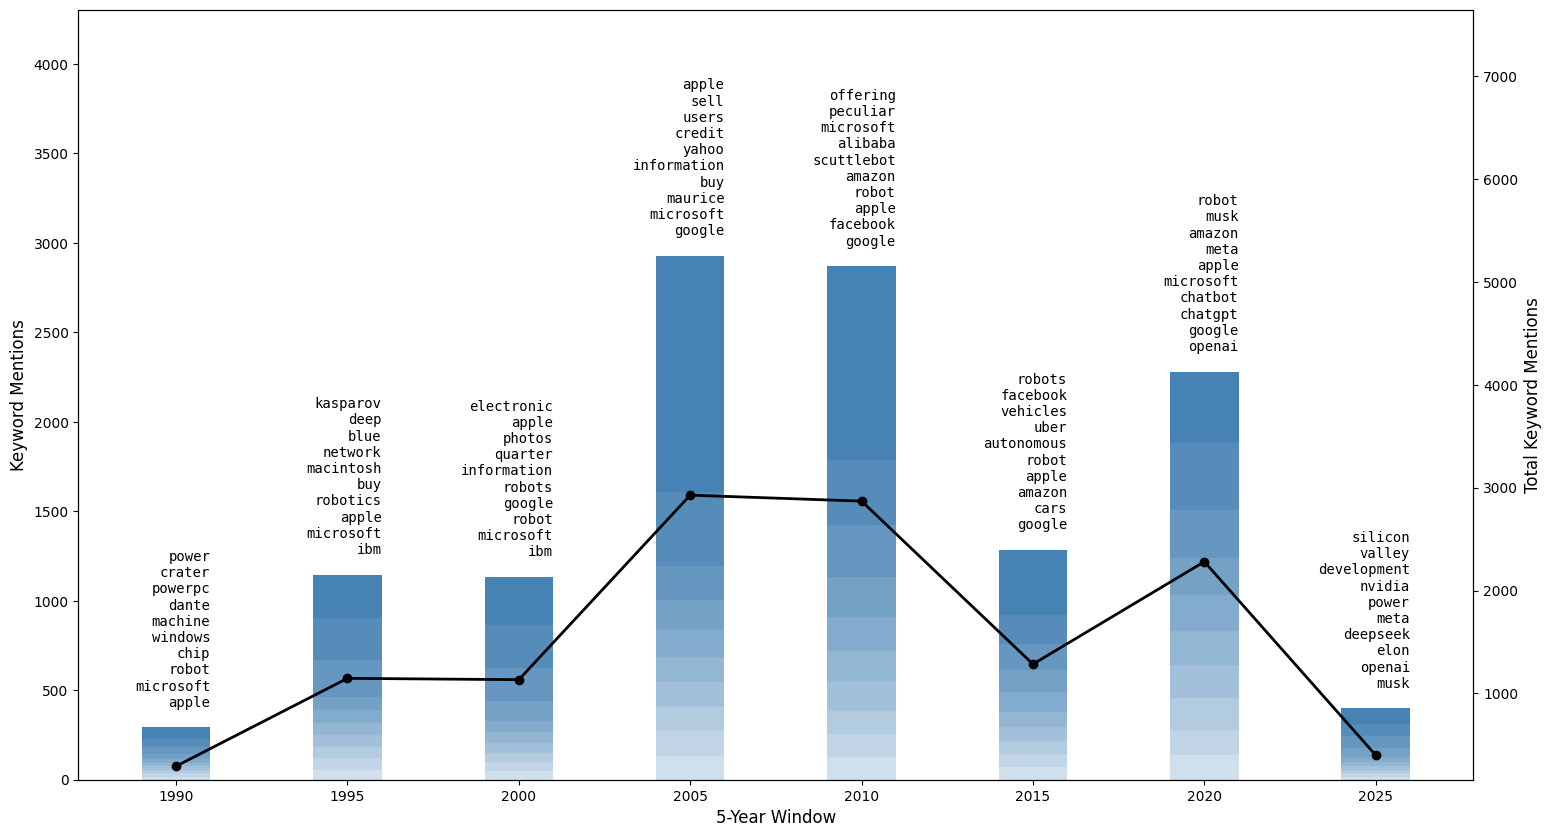

In [ ]:
# Settings
fig, ax = plt.subplots(figsize=(18, 10))
bar_width = 4
gap = 6  # spacing between bars

# Sorted 5-year windows
windows = sorted(window_keywords.keys())

# Color gradient: blue fade
def blue_gradient(n):
    base = mcolors.to_rgba("steelblue")
    return [(base[0], base[1], base[2], alpha) for alpha in np.linspace(0.25, 1, n)]

# Store total counts for line plot
totals = []
bar_positions = []

# Loop through each window
for idx, window in enumerate(windows):
    keywords_freq = sorted(window_keywords[window], key=lambda x: x[1])


    # Decompose
    keywords = [k for k, _ in keywords_freq]
    freqs = np.array([v for _, v in keywords_freq])
    bottoms = np.cumsum([0] + list(freqs[:-1]))
    colors = blue_gradient(len(keywords))

    xpos = idx * (bar_width + gap)
    bar_positions.append(xpos)
    totals.append(sum(freqs))

    # Plot stacked bar
    for i in range(len(keywords)):
        ax.bar(xpos, freqs[i], bottom=bottoms[i], width=bar_width, color=colors[i])

    # Add mini legend text above bar
    legend_text = "\n".join(keywords)
    ax.text(
        xpos + bar_width / 2,                     # center of bar
        sum(freqs) + 100,                         # place above bar
        legend_text,
        ha='right', va='bottom',
        fontsize=10, family='monospace'
    )

# Line for total keyword mentions
ax2 = ax.twinx()
ax2.plot(bar_positions, totals, color='black', marker='o', linewidth=2, label='Total Keywords')
ax2.set_ylabel('Total Keyword Mentions', fontsize=12)
# Extend Y-axis
current_ylim = ax2.get_ylim()
ax2.set_ylim(current_ylim[0], current_ylim[1] * 2.5)  # or *2.2, *2.7 depending on space


# Formatting
# Extend Y-axis
current_ylim = ax.get_ylim()
ax.set_ylim(current_ylim[0], current_ylim[1] * 1.4)  # or *2.2, *2.7 depending on space
ax.set_xticks(bar_positions)
ax.set_xticklabels(windows)
ax.set_xlabel('5-Year Window', fontsize=12)
ax.set_ylabel('Keyword Mentions', fontsize=12)
ax.set
